## Introduction
I will introduce a simple method using lightGBM as a starter.

## import
Load the necessary libraries.

In [1]:
import os
import pandas as pd
from kaggle.competitions import nflrush
import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import KFold
import lightgbm as lgb
import gc
import pickle
import tqdm
import category_encoders

## train data
The shape of train data is 509762 × 49.
But, since one set consists of 22 lines, the actual number of data is 23171.
I converted it to a format that is easy to use.

In [2]:
env = nflrush.make_env()
train_df = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2020/train.csv', low_memory=False)

In [3]:
train_df

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,...,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509757,2018123015,20181230154157,home,86.77,24.20,2.14,2.12,0.22,44.55,15.31,...,17,CenturyLink Field,"Seattle, WA",Outdoor,FieldTurf,Cloudy,45.0,76.0,5,SE
509758,2018123015,20181230154157,home,86.76,27.18,1.16,0.66,0.11,53.63,42.80,...,17,CenturyLink Field,"Seattle, WA",Outdoor,FieldTurf,Cloudy,45.0,76.0,5,SE
509759,2018123015,20181230154157,home,87.26,27.05,2.59,1.18,0.26,3.96,21.12,...,17,CenturyLink Field,"Seattle, WA",Outdoor,FieldTurf,Cloudy,45.0,76.0,5,SE
509760,2018123015,20181230154157,home,84.57,24.37,4.36,1.79,0.47,148.08,183.34,...,17,CenturyLink Field,"Seattle, WA",Outdoor,FieldTurf,Cloudy,45.0,76.0,5,SE


In [4]:
unused_columns = ["GameId","PlayId","Team","Yards","TimeHandoff","TimeSnap"]

In [5]:
unique_columns = []
for c in train_df.columns:
    if c not in unused_columns+["PlayerBirthDate"] and len(set(train_df[c][:11]))!= 1:
        unique_columns.append(c)
        print(c," is unique")
# unique_columns+=["BirthY"]

X  is unique
Y  is unique
S  is unique
A  is unique
Dis  is unique
Orientation  is unique
Dir  is unique
NflId  is unique
DisplayName  is unique
JerseyNumber  is unique
PlayerHeight  is unique
PlayerWeight  is unique
PlayerCollegeName  is unique
Position  is unique


In [6]:
ok = True
for i in range(0,509762,22):
    p=train_df["PlayId"][i]
    for j in range(1,22):
        if(p!=train_df["PlayId"][i+j]):
            ok=False
            break
print("train data is sorted by PlayId." if ok else "train data is not sorted by PlayId.")
ok = True
for i in range(0,509762,11):
    p=train_df["Team"][i]
    for j in range(1,11):
        if(p!=train_df["Team"][i+j]):
            ok=False
            break
print("train data is sorted by Team." if ok else "train data is not sorted by Team.")

train data is sorted by PlayId.
train data is sorted by Team.


Since the training data was sorted, preprocessing can be done easily.

In [7]:
all_columns = []
for c in train_df.columns:
    if c not in unique_columns + unused_columns+["DefensePersonnel","GameClock","PlayerBirthDate"]:
        all_columns.append(c)
all_columns.append("DL")
all_columns.append("LB")    
all_columns.append("DB")
all_columns.append("GameHour")   
for c in unique_columns:
    for i in range(22):
        all_columns.append(c+str(i))

In [8]:
print(all_columns)

['Season', 'YardLine', 'Quarter', 'PossessionTeam', 'Down', 'Distance', 'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay', 'NflIdRusher', 'OffenseFormation', 'OffensePersonnel', 'DefendersInTheBox', 'PlayDirection', 'HomeTeamAbbr', 'VisitorTeamAbbr', 'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'DL', 'LB', 'DB', 'GameHour', 'X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'Y0', 'Y1', 'Y2', 'Y3', 'Y4', 'Y5', 'Y6', 'Y7', 'Y8', 'Y9', 'Y10', 'Y11', 'Y12', 'Y13', 'Y14', 'Y15', 'Y16', 'Y17', 'Y18', 'Y19', 'Y20', 'Y21', 'S0', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20', 'S21', 'A0', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A21', 'D

In [9]:
lbl_dict = {}
for c in train_df.columns:
    if c == "DefensePersonnel":
        arr = [[int(s[0]) for s in t.split(", ")] for t in train_df["DefensePersonnel"]]
        train_df["DL"] = np.array([a[0] for a in arr])
        train_df["LB"] = np.array([a[1] for a in arr])
        train_df["DB"] = np.array([a[2] for a in arr])
    elif c == "GameClock":
        arr = [[int(s) for s in t.split(":")] for t in train_df["GameClock"]]
        train_df["GameHour"] = pd.Series([a[0] for a in arr])
    elif c == "PlayerBirthDate":
        arr = [[int(s) for s in t.split("/")] for t in train_df["PlayerBirthDate"]]
        train_df["BirthY"] = pd.Series([a[2] for a in arr])
    # elif c == "PlayerHeight":
    #     arr = [float(s.split("-")[0]) * 30.48 + float(s.split("-")[1]) * 2.54
    #         for s in list(train_df["PlayerHeight"])]
    #     train_df["PlayerHeight"] = pd.Series(arr)
    elif train_df[c].dtype=='object' and c not in unused_columns: 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_df[c].values))
        lbl_dict[c] = lbl
        train_df[c] = lbl.transform(list(train_df[c].values))

In [10]:
train_data=np.zeros((509762//22,len(all_columns)))
for i in tqdm.tqdm(range(0,509762,22)):
    count=0
    for c in all_columns:
        if c in train_df:
            train_data[i//22][count] = train_df[c][i]
            count+=1
    for c in unique_columns:
        for j in range(22):
            train_data[i//22][count] = train_df[c][i+j]
            count+=1        

100%|██████████| 23171/23171 [03:23<00:00, 113.66it/s]


In [11]:
y_train_ = np.array([train_df["Yards"][i] for i in range(0,509762,22)])
X_train = pd.DataFrame(data=train_data,columns=all_columns)

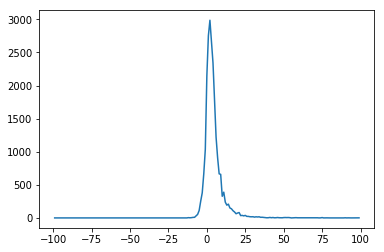

In [12]:
data = [0 for i in range(199)]
for y in y_train_:
    data[int(y+99)]+=1
plt.plot([i-99 for i in range(199)],data)

Since the variance is small, I standardized the objective variable.

In [13]:
# scaler = preprocessing.StandardScaler()
# scaler.fit([[y] for y in y_train_])
# y_train = np.array([y[0] for y in scaler.transform([[y] for y in y_train_])])
scaler = preprocessing.StandardScaler()
scaler.fit(y_train_.reshape(-1, 1))
y_train = scaler.transform(y_train_.reshape(-1, 1)).flatten()

## train
I used LGBMRegressor.
I wanted to use multi-class classification, but the number of datasets was small and it was difficult to split them including all labels.

In [14]:
folds = 10
seed = 222
kf = KFold(n_splits = folds, shuffle = True, random_state=seed)
y_valid_pred = np.zeros(X_train.shape[0])
models = []

for tr_idx, val_idx in kf.split(X_train, y_train):
    tr_x, tr_y = X_train.iloc[tr_idx,:], y_train[tr_idx]
    vl_x, vl_y = X_train.iloc[val_idx,:], y_train[val_idx]
            
    print(len(tr_x),len(vl_x))
    tr_data = lgb.Dataset(tr_x, label=tr_y)
    vl_data = lgb.Dataset(vl_x, label=vl_y)  
    clf = lgb.LGBMRegressor(n_estimators=200,learning_rate=0.01)
    clf.fit(tr_x, tr_y,
        eval_set=[(vl_x, vl_y)],
        early_stopping_rounds=20,
        verbose=False)
    y_valid_pred[val_idx] += clf.predict(vl_x, num_iteration=clf.best_iteration_)
    models.append(clf)

gc.collect()

20853 2318
20854 2317
20854 2317
20854 2317
20854 2317
20854 2317
20854 2317
20854 2317
20854 2317
20854 2317


123

## evaluation
Continuous Ranked Probability Score (CRPS) is derived based on the predicted scalar value.
The CRPS is computed as follows:
$$
C=\frac{1}{199N}\sum_{m=1}^N\sum_{n=-99}^{99}(P(y\geq n)-H(n-Y_m))^2
$$
$H(x)=1$ if $x\geq 0$ else $0$

In [15]:
y_pred = np.zeros((509762//22,199))
y_ans = np.zeros((509762//22,199))

for i,p in enumerate(np.round(scaler.inverse_transform(y_valid_pred))):
    p+=99
    for j in range(199):
        if j>=p+10:
            y_pred[i][j]=1.0
        elif j>=p-10:
            y_pred[i][j]=(j+10-p)*0.05

for i,p in enumerate(scaler.inverse_transform(y_train)):
    p+=99
    for j in range(199):
        if j>=p:
            y_ans[i][j]=1.0

print("validation score:",np.sum(np.power(y_pred-y_ans,2))/(199*(509762//22)))

validation score: 0.015568569401753912


## make submission

When there is a label that does not exist in the training data, it is handled as nan.
If you can check the error one by one and complement it, you will get better score.

In [16]:
index = 0
for (test_df, sample_prediction_df) in tqdm.tqdm(env.iter_test()):
    for c in test_df.columns:
        if c == "DefensePersonnel":
            try:
                arr = [[int(s[0]) for s in t.split(", ")] for t in test_df["DefensePersonnel"]]
                test_df["DL"] = [a[0] for a in arr]
                test_df["LB"] = [a[1] for a in arr]
                test_df["DB"] = [a[2] for a in arr]
            except:
                test_df["DL"] = [np.nan for i in range(22)]
                test_df["LB"] = [np.nan for i in range(22)]
                test_df["DB"] = [np.nan for i in range(22)]
        elif c == "GameClock":
            try:
                arr = [[int(s) for s in t.split(":")] for t in test_df["GameClock"]]
                test_df["GameHour"] = pd.Series([a[0] for a in arr])
            except:
                test_df["GameHour"] = [np.nan for i in range(22)]
        elif c == "PlayerBirthDate":
            try:
                arr = [[int(s) for s in t.split("/")] for t in test_df["PlayerBirthDate"]]
                test_df["BirthY"] = pd.Series([a[2] for a in arr])
            except:
                test_df["BirthY"] = [np.nan for i in range(22)]
        # elif c == "PlayerHeight":
        #     try:
        #         arr = [float(s.split("-")[0]) * 30.48 + float(s.split("-")[1]) * 2.54
        #             for s in list(test_df["PlayerHeight"])]
        #         test_df["PlayerHeight"] = pd.Series(arr)
        #     except:
        #         test_df["PlayerHeight"] = [np.nan for i in range(22)]
        elif c in lbl_dict and test_df[c].dtype=='object'and c not in unused_columns\
            and not pd.isnull(test_df[c]).any():
            try:
                test_df[c] = lbl_dict[c].transform(list(test_df[c].values))
            except:
                test_df[c] = [np.nan for i in range(22)]
    count=0
    test_data = np.zeros((1,len(all_columns)))

    for c in all_columns:
        if c in test_df:
            try:
                test_data[0][count] = test_df[c][index]
            except:
                test_data[0][count] = np.nan
            count+=1
    for c in unique_columns:
        for j in range(22):
            try:
                test_data[0][count] = test_df[c][index + j]
            except:
                test_data[0][count] = np.nan
            count+=1        
    y_pred = np.zeros(199)        
    y_pred_p = np.sum(np.round(scaler.inverse_transform(
        [model.predict(test_data)[0] for model in models])))/folds
    y_pred_p += 99
    for j in range(199):
        if j>=y_pred_p+10:
            y_pred[j]=1.0
        elif j>=y_pred_p-10:
            y_pred[j]=(j+10-y_pred_p)*0.05
    env.predict(pd.DataFrame(data=[y_pred],columns=sample_prediction_df.columns))
    index += 22
env.write_submission_file()

3438it [03:44, 15.29it/s]


Your submission file has been saved!  Once you `Commit` your Notebook and it finishes running, you can submit the file to the competition from the Notebook Viewer `Output` tab.


The organizers seemed to expect to predict one by one, so I did. 
However, it seems that it is likely to be faster to predict at once after all the evaluation data is acquired by dummy input.


This model is a simple one that has not been tuned, so I think we can still expect a better score.
Please let me know if you have any opinions or advice.